In [56]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 22.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=330c50ad0908918987f4a6c1d41e95451cc2681bab323f065bee501ff685bd32
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [28]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('my_app').getOrCreate()
bank_copy=spark.read.csv('/content/ML_hw_dataset (1).csv',header=True,inferSchema=True)

In [29]:
bank_copy.show()


+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no| cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|      

In [30]:
bank_copy.describe().show()


+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|          campaign|             pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|  

In [32]:
from pyspark.sql.functions import isnan,when,count,col
bank_copy.select([count(when(isnan(i)|col(i).isNull(),i)).alias(i) for i in bank_copy.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [36]:
from pyspark.sql.functions import col

numeric_cols=[c for c ,t in bank_copy.dtypes if t in ['int','double','float','long']]

for col_name in numeric_cols:
  q1=bank_copy.approxQuantile(col_name,[0.25],0.01)[0]
  q3=bank_copy.approxQuantile(col_name,[0.75],0.01)[0]
  iqr=q3-q1

  k=1.5
  lower_bound=q1-k*iqr
  upper_bound=q3+k*iqr
  
  bank_copy=bank_copy.filter((col(col_name) >= lower_bound) & (col(col_name)<=upper_bound))

In [37]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
string_cols = [col_name for col_name, col_type in bank_copy.dtypes if col_type == 'string']
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed") for col_name in string_cols]
indexer_pipeline = Pipeline(stages=indexers)
bank_copy_indexed = indexer_pipeline.fit(bank_copy).transform(bank_copy)

In [38]:
bank_copy.show()


+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 34|  housemaid|  single|  university.degree|     no|     no|  no|telephone|  may|        fri|      62|       2|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.864|     5191.0|  0|
| 52|   services| married|        high.school|unknown|    yes|  no| cellular|  jul|        thu|     117|       2|  999|       0|nonexistent|         1.4|        93.

In [39]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler,StandardScaler,MinMaxScaler

spark = SparkSession.builder.appName("Normalization").getOrCreate()

numeric_cols = [col for col, dtype in bank_copy.dtypes if dtype == "int" or dtype == "double"]
df_numeric = bank_copy.select(numeric_cols)

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_numeric_assembled = assembler.transform(df_numeric).select("features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_numeric_assembled)
df_normalized = scaler_model.transform(df_numeric_assembled)

df_normalized = df_normalized.withColumn("id", monotonically_increasing_id())
df = bank_copy.withColumn("id", monotonically_increasing_id())

df_normalized = df_normalized.join(df, "id", "outer").drop(df_normalized["id"])
df_normalized.show(10)

+---+--------------------+--------------------+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| id|            features|     scaled_features|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+--------------------+--------------------+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|  0|[34.0,62.0,2.0,99...|[0.36585365853658...| 34|  housemaid|  single|  university.degree|     no|     no|  no|telephone|  may|        fri|      62|       2|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.8

In [54]:
pdf=bank_copy.toPandas()
import plotly.express as px

fig = px.box(pdf, x="job", y="duration", color="y")
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [53]:
fig = px.scatter(pdf, x="campaign", y="duration", color="y")
fig.show()

In [52]:
pdf=bank_copy.toPandas()

fig = px.scatter(pdf, x="education", y="campaign", color="y")
fig.show()

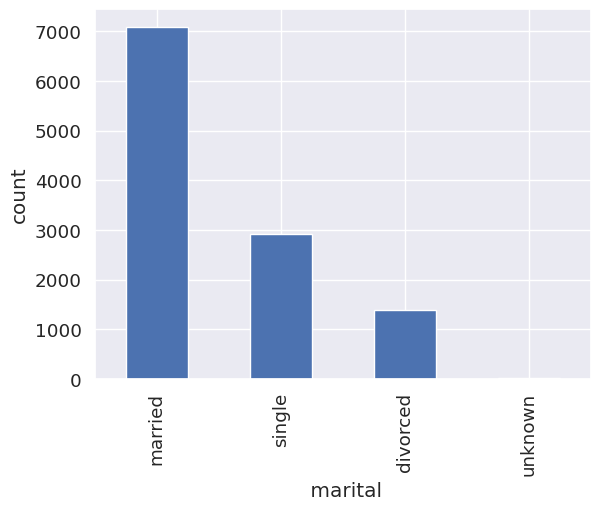

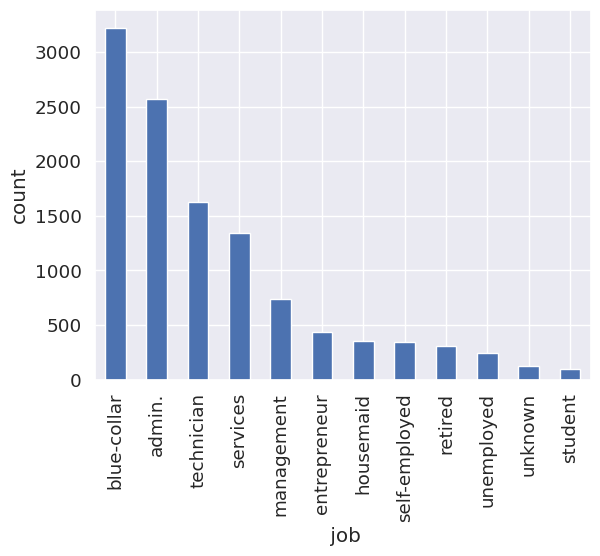

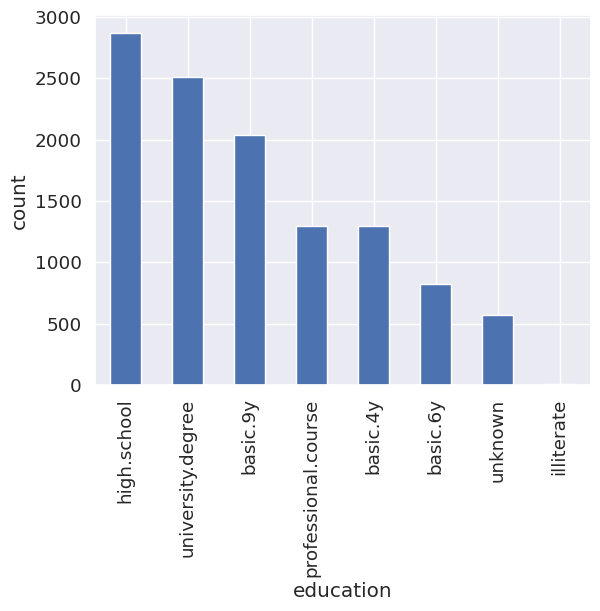

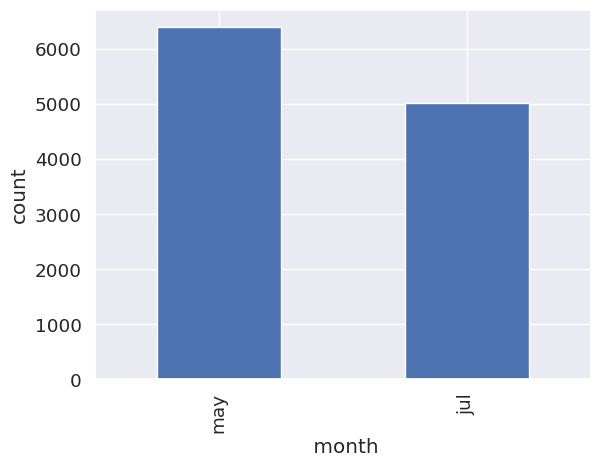

In [51]:
import pandas as pd
import matplotlib.pyplot as plt



# شمارش تعداد افراد براساس وضعیت تاهل
marital_counts = pdf["marital"].value_counts()

# رسم نمودار
marital_counts.plot(kind="bar")

# تنظیم نام محور x
plt.xlabel(" marital")

# تنظیم نام محور y
plt.ylabel("count")

# نمایش نمودار
plt.show()


marital_counts = pdf["job"].value_counts()
marital_counts.plot(kind="bar")
plt.xlabel(" job")
plt.ylabel("count")
plt.show()

marital_counts = pdf["education"].value_counts()
marital_counts.plot(kind="bar")
plt.xlabel("education")
plt.ylabel("count")
plt.show()

marital_counts = pdf["month"].value_counts()
marital_counts.plot(kind="bar")
plt.xlabel(" month")
plt.ylabel("count")
plt.show()

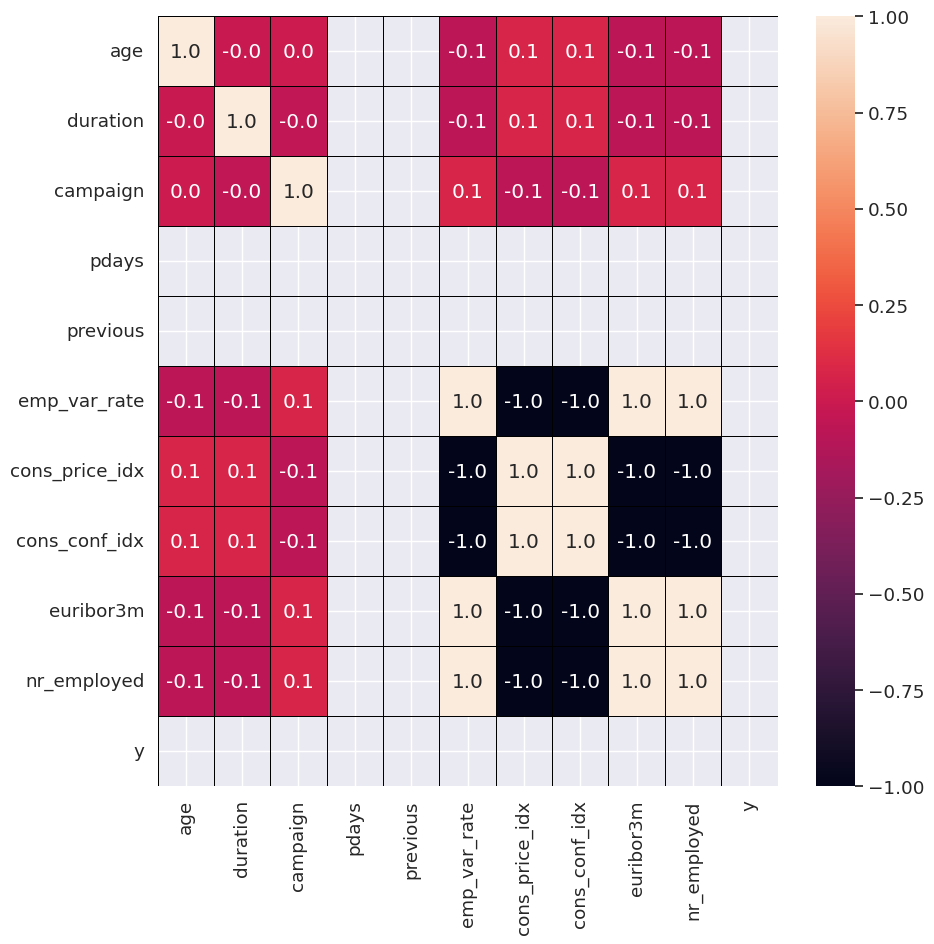

In [50]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [c for c,d in df.dtypes if d in ['int','double']]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
assembled_data = assembler.transform(df).select('features')

correlation_matrix = Correlation.corr(assembled_data, 'features').head()
corr_array = correlation_matrix[0].toArray()

col_names = [c for c in numeric_cols]

import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pdf.corr(), annot=True, linewidths=0.5, linecolor="black", fmt=".1f", ax=ax)
plt.show()

In [ ]:
##########################

In [43]:

from pyspark.ml.feature import PCA
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_df = assembler.transform(df_indexed)

pca = PCA(k=11, inputCol="features", outputCol="pca_features")
model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df).select("pca_features","y")
pca_df.show()


+--------------------+---+
|        pca_features|  y|
+--------------------+---+
|[164.288423220411...|  0|
|[92.5674110536621...|  0|
|[16.6209344154738...|  0|
|[71.2857759001451...|  0|
|[94.6201475265320...|  0|
|[58.2935981488265...|  0|
|[294.281270059222...|  0|
|[-10.704532842247...|  0|
|[195.284052490825...|  0|
|[-4.7080462750216...|  0|
|[69.2883043096327...|  0|
|[22.2938414635782...|  0|
|[47.2941646220111...|  0|
|[248.611398047891...|  0|
|[-21.379720980353...|  0|
|[299.278413471070...|  0|
|[167.286357674410...|  0|
|[325.563711569857...|  0|
|[41.2959332731283...|  0|
|[56.2888656839512...|  0|
+--------------------+---+
only showing top 20 rows



In [55]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


lr = LogisticRegression(labelCol='y', featuresCol='pca_features', maxIter=5)


train_data, test_data = pca_df.randomSplit([0.8, 0.2], seed=42)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol='y', rawPredictionCol='prediction')
auc = evaluator.evaluate(predictions)
print(auc)

print(lr_model.evaluate(test_data).accuracy)

0.0
1.0


In [46]:
ns = lr_model.evaluate(test_data)
ns.accuracy

1.0

In [47]:
print(ns.precisionByLabel)
print(ns.recallByLabel)

[1.0]
[1.0]
